# H2O


h2o to do autoML

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/include_algos.html

Personally, I like h2o better than AutoKeras, however the structured regression is unique in AutoKeras.

# Initialize

In [1]:
import h2o
from h2o.automl import H2OAutoML

In [17]:
import importlib
import os
import sys

import pandas as pd
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [23]:
from morai.experience import charters, experience
from morai.forecast import preprocessors
from morai.utils import custom_logger

In [5]:
logger = custom_logger.setup_logging(__name__)

In [6]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [7]:
pd.options.display.float_format = "{:,.2f}".format

# Data

In [8]:
pl_parquet_path = r"files\dataset\mortality_grouped.parquet"

In [9]:
# reading in the dataset
# the partitioned columns need to be casted back correctly
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [10]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]}"
)

row count: 1793414 
exposures: 9932426374835.434


In [11]:
grouped_df = lzdf.collect()

In [12]:
grouped_df = grouped_df.to_pandas()

# Preparing Data

## Filter

In [13]:
model_data = grouped_df[
    (grouped_df["attained_age"] >= 50)
    # & (grouped_df["attained_age"] <= 95)
    & (grouped_df["issue_age"] >= 30)
    & (grouped_df["issue_age"] <= 80)
].copy()
model_data = model_data.reset_index(drop=True)

In [14]:
del grouped_df

## Calculated Fields

In [18]:
model_data["capped_duration"] = model_data["duration"].clip(upper=26)
model_data["qx_log_raw"] = np.log(model_data["qx_raw"] + 1)
binned_face_dict = {
    "01: 0 - 9,999": "01: 0 - 24,999",
    "02: 10,000 - 24,999": "01: 0 - 24,999",
    "03: 25,000 - 49,999": "02: 25,000 - 99,999",
    "04: 50,000 - 99,999": "02: 25,000 - 99,999",
    "05: 100,000 - 249,999": "03: 100,000 - 249,999",
    "06: 250,000 - 499,999": "04: 250,000 - 4,999,999",
    "07: 500,000 - 999,999": "04: 250,000 - 4,999,999",
    "08: 1,000,000 - 2,499,999": "04: 250,000 - 4,999,999",
    "09: 2,500,000 - 4,999,999": "04: 250,000 - 4,999,999",
    "10: 5,000,000 - 9,999,999": "05: 5,000,000+",
    "11: 10,000,000+": "05: 5,000,000+",
}
model_data["binned_face"] = model_data["face_amount_band"].map(binned_face_dict)
model_data["binned_face"] = model_data["binned_face"].astype("category")

## Feature Dictionary

In [21]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration", "observation_year", "issue_year"],
    "ordinal": [
        "sex",
        "smoker_status",
    ],
    "ohe": [
        "binned_face",
        "insurance_plan",
        "class_enh",
    ],
    "nominal": [],
}

# H2O

In [20]:
model_name = "h2o"

In [24]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=True,
)

 2024-12-30 11:54:54 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-12-30 11:54:54 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-12-30 11:54:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['attained_age', 'duration', 'observation_year', 'issue_year'] 
 2024-12-30 11:54:54 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['sex', 'smoker_status'] 
 2024-12-30 11:54:55 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded (dropping first col): ['binned_face', 'insurance_plan', 'class_enh'] 
 2024-12-30 11:54:55 | morai.forecast.preprocessors | INFO     | standardizing the data with StandardScaler 


In [25]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

## Initialize

In [28]:
h2o.init()
hf = h2o.H2OFrame(pd.concat([X_train, y_train, weights_train], axis=1))
x_test_hf = h2o.H2OFrame(X_test)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,13 mins 49 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 28 days
H2O_cluster_name:,H2O_from_python_johnk_9v3qnf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.501 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
predictors = hf.drop(["qx_raw","amount_exposed"]).columns
response = "qx_raw"
weights = "amount_exposed"

In [62]:
# stopping_metric: Specify the metric to use for early stopping.
# algos: DRF, GLM, XGBoost, GBM, DeepLearning, StackedEnsemble
aml = H2OAutoML(
    max_models=7,
    include_algos=["DRF", "GLM", "XGBoost", "GBM", "DeepLearning"],
    max_runtime_secs=360,
    stopping_metric="AUTO",
    sort_metric="AUTO",
)

## Train

In [63]:
# Train the model
aml.train(x=predictors, y=response, weights_column=weights, training_frame=hf)

AutoML progress: |█
15:13:18.688: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████| (done) 100%


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,45.0,45.0,68771.0,7.0,7.0,6.5333333,1.0,128.0,117.1555560
,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2024-12-30 15:16:20,0.003 sec,0.0,0.0382159,0.0079854,0.0014605,0.0360600,0.0078028,0.0013003
,2024-12-30 15:16:21,1.743 sec,5.0,0.0361049,0.0074071,0.0013036,0.0346115,0.0072674,0.0011980
,2024-12-30 15:16:23,3.508 sec,10.0,0.0353007,0.0071472,0.0012461,0.0342133,0.0070381,0.0011705
,2024-12-30 15:16:25,5.468 sec,15.0,0.0346008,0.0069573,0.0011972,0.0340238,0.0068843,0.0011576
,2024-12-30 15:16:27,7.247 sec,20.0,0.0342045,0.0068457,0.0011700,0.0339593,0.0067960,0.0011532
,2024-12-30 15:16:29,9.036 sec,25.0,0.0339179,0.0067787,0.0011504,0.0339373,0.0067572,0.0011517
,2024-12-30 15:16:30,10.793 sec,30.0,0.0337102,0.0067272,0.0011364,0.0339156,0.0067213,0.0011503
,2024-12-30 15:16:32,12.460 sec,35.0,0.0334464,0.0066833,0.0011187,0.0339910,0.0067185,0.0011554


In [64]:
lb = aml.leaderboard
lb
# aml.leader

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_2_AutoML_4_20241230_151317,0.0339568,0.00115306,0.00668951,0.0261857,0.00115306
GBM_3_AutoML_4_20241230_151317,0.0341599,0.0011669,0.00668315,0.0263703,0.0011669
GBM_4_AutoML_4_20241230_151317,0.0342382,0.00117226,0.0066894,0.0265188,0.00117226
GLM_1_AutoML_4_20241230_151317,0.0350654,0.00122958,0.00879172,0.0270441,0.00122958
DRF_1_AutoML_4_20241230_151317,0.0354536,0.00125696,0.00674919,0.0277415,0.00125696
XRT_1_AutoML_4_20241230_151317,0.0356381,0.00127008,0.00679751,0.0279093,0.00127008
GBM_1_AutoML_4_20241230_151317,0.0365411,0.00133525,0.00709424,0.0287485,0.00133525


## Predict

In [65]:
X_h20 = h2o.H2OFrame(X)
predictions = aml.leader.predict(X_h20).as_data_frame(use_multi_thread=True).to_numpy()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


## Results

In [58]:
model_name = 'h2o'
model_data = experience.calc_qx_exp_ae(
    model_data=model_data,
    predictions=predictions,
    model_name=model_name,
    exposure_col="amount_exposed",
    actual_col="death_claim_amount",
)

 2024-12-30 15:10:44 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


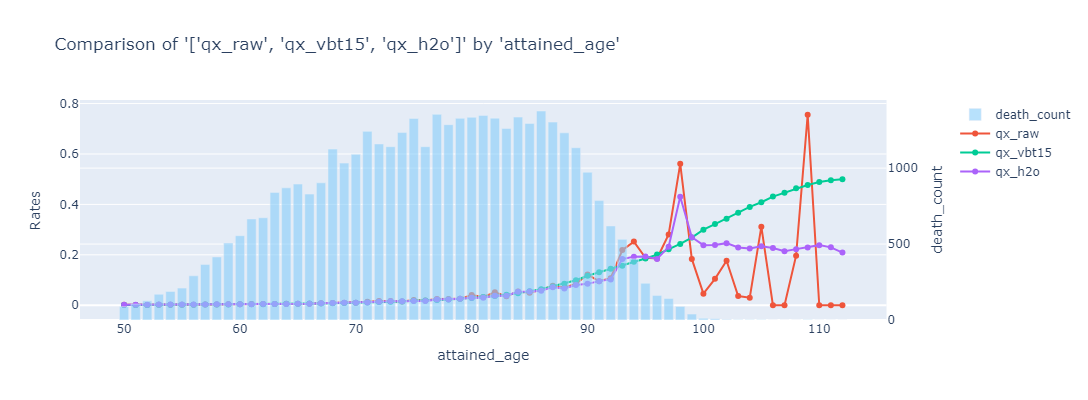

In [59]:
charters.compare_rates(
    model_data[model_data["insurance_plan"].isin(["UL"])],
    x_axis="attained_age",
    rates=["qx_raw", "qx_vbt15", "qx_h2o"],
    weights=["amount_exposed"],
    secondary="death_count",
    y_log=False,
)

# SHAP

## H2O

In [ ]:
# aml.explain(hf)